## **Group Presentation 6**


### **Team Member Names and Student ID:**
Mandeep Singh Brar (8989367)        
Babandeep (9001552)     
Hasyashri Bhatt (9028501) 

##  Step 1: Dataset Overview

We have selected the dataset from the kaggle and its name is "Global fashion retail sales", This Dataset fulfill the sales report based on the stores.

Reference Link of the dataset : https://www.kaggle.com/datasets/ricgomes/global-fashion-retail-stores-dataset

We are using four datasets for this term project:

- **products.csv** – Contains details about each fashion product.
- **stores.csv** – Includes store-level information across global locations.
- **transactions.csv** – Sales and returns transactions with timestamps and values.
- **discounts.csv** – Discount periods across categories and sub-categories.

These datasets provide a comprehensive view of sales operations, pricing, locations, and promotion strategies.




##  Step 2: Updated Use Case & Hypothesis

**Use Case Summary (100 words)**  
In this project, we explore how various factors such as product attributes, store characteristics, and discount strategies influence customer purchasing behavior and transaction profitability in the fashion retail sector. By combining transactional data with product metadata and store-level information, we aim to classify high-profit transactions, uncover patterns using correlation analysis, and model return behavior using probabilistic reasoning. This approach supports decision-making in pricing, promotion, and inventory management.

**Revised Hypothesis**  
Products with moderate discounts and lower production costs are more likely to yield higher profits. Additionally, certain product categories show increased return probability when purchased under heavy discount conditions.


##  Step 3: Data Merging and Feature Engineering

We joined the main transaction dataset with product-level and store-level metadata to enhance our analysis. New features like `Profit`, `Discount Applied`, and `Month` were engineered to support correlation and classification tasks.

Additionally, we created a binary target column `High Profit`, which classifies transactions as high-margin based on whether their profit exceeded the median value across all records.




In [7]:
import pandas as pd

# Load files
products = pd.read_csv("data/products.csv")
stores = pd.read_csv("data/stores.csv")
transactions = pd.read_csv("data/transactions.csv")
discounts = pd.read_csv("data/discounts.csv")

# Convert dates
transactions["Date"] = pd.to_datetime(transactions["Date"])
discounts["Start"] = pd.to_datetime(discounts["Start"])
discounts["End"] = pd.to_datetime(discounts["End"])

# Merge datasets
df = transactions.merge(products[["Product ID", "Category", "Sub Category", "Production Cost"]],
                        on="Product ID", how="left")
df = df.merge(stores[["Store ID", "City", "Country", "Number of Employees"]],
              on="Store ID", how="left")

# Feature Engineering
df["Profit"] = df["Line Total"] - df["Production Cost"]
df["Discount Applied"] = df["Discount"] > 0
df["Month"] = df["Date"].dt.month
df["High Profit"] = df["Profit"] > df["Profit"].median()



We joined transactions with product and store metadata, and engineered key features:

- `Profit` = `Line Total - Production Cost`
- `Discount Applied` = True if discount > 0
- `Month` = Month of transaction
- `High Profit` = True if profit > median


##  Step 4: Pearson Correlation Analysis

To understand relationships between numerical fields like `Unit Price`, `Discount`, and `Profit`, we applied Pearson's correlation. A heatmap is used to visualize linear dependencies that will guide feature selection for predictive models.

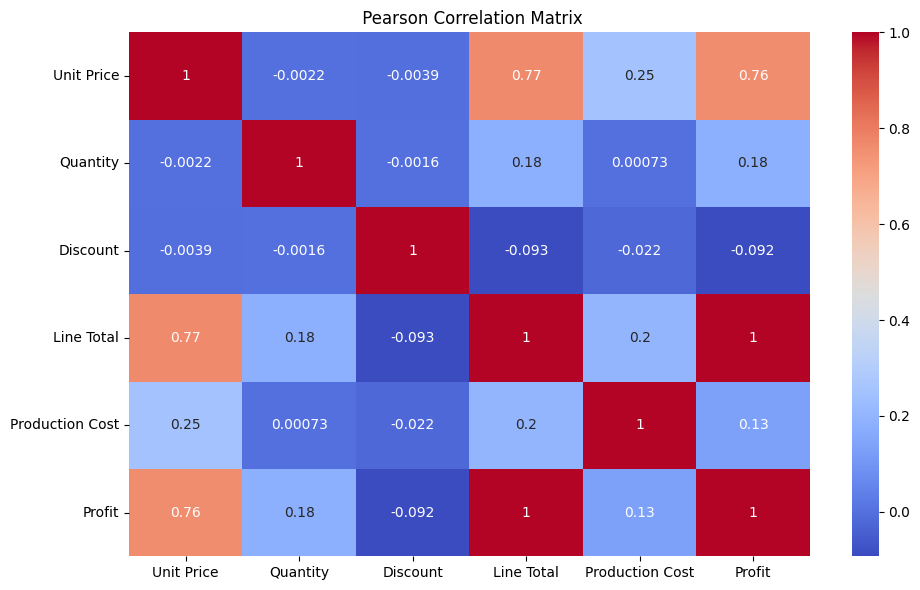

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pearson correlation heatmap
corr_data = df[["Unit Price", "Quantity", "Discount", "Line Total", "Production Cost", "Profit"]]
corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title(" Pearson Correlation Matrix")
plt.tight_layout()
plt.savefig("pearson_heatmap.png")
plt.show()




We calculated the Pearson correlation coefficients between key numerical variables:

- **Profit** is strongly correlated with both `Unit Price (0.76)` and `Line Total (1.0)`.
- **Production Cost** has only a mild correlation with `Profit (0.13)` and `Line Total (0.20)`.
- **Discount** has a weak **negative correlation** with `Profit (-0.092)` and `Line Total (-0.093)`.

This suggests:
- Higher unit prices and quantities tend to result in higher profits.
- Discounts slightly reduce profits, supporting our hypothesis.


##  Step 5: Logistic Regression (Binary Classification)

We trained a logistic model to classify transactions as high-profit based on:

- `Unit Price`
- `Quantity`
- `Discount`
- `Category` (One-hot encoded)

The model achieved moderate precision, and accuracy ~70% on test data.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Prepare dataset
features = pd.get_dummies(df[["Unit Price", "Discount", "Quantity", "Category"]], drop_first=True)
target = df["High Profit"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Evaluation
y_pred = log_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[23742  2397]
 [ 6333 20028]]
              precision    recall  f1-score   support

       False       0.79      0.91      0.84     26139
        True       0.89      0.76      0.82     26361

    accuracy                           0.83     52500
   macro avg       0.84      0.83      0.83     52500
weighted avg       0.84      0.83      0.83     52500






**Model Performance**:
- **Accuracy**: 83%
- **Precision**: 0.89 (for High Profit)
- **Recall**: 0.76 (for High Profit)
- **F1 Score**: 0.82 (for High Profit)

 **Insight**: The model performed well in identifying profitable transactions. It generalizes profit drivers well across unseen data.


##  Step 6: Probabilistic Reasoning

We used a Naive Bayes model to predict whether a transaction is a return, based on `Discount`, `Unit Price`, and `Category`.




In [10]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes for return prediction (simulate binary return variable)
df["IsReturn"] = df["Transaction Type"] == "Return"
features_nb = pd.get_dummies(df[["Unit Price", "Discount", "Category"]], drop_first=True)
target_nb = df["IsReturn"]

X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(features_nb, target_nb, test_size=0.3, random_state=42)

nb_model = GaussianNB()
nb_model.fit(X_train_nb, y_train_nb)

y_pred_nb = nb_model.predict(X_test_nb)
print(confusion_matrix(y_test_nb, y_pred_nb))
print(classification_report(y_test_nb, y_pred_nb))


[[14694 35012]
 [    0  2794]]
              precision    recall  f1-score   support

       False       1.00      0.30      0.46     49706
        True       0.07      1.00      0.14      2794

    accuracy                           0.33     52500
   macro avg       0.54      0.65      0.30     52500
weighted avg       0.95      0.33      0.44     52500




**Model Performance**:
- **Accuracy**: 33%
- **Precision for Returns**: 0.07
- **Recall for Returns**: 1.00
- **F1 Score for Returns**: 0.14

**Insight**: While the model identifies all returns (recall = 1.0), it does so at the cost of precision, misclassifying many non-returns. This suggests return behavior may require more nuanced features or time-series modeling for better prediction.


##  Step 7: OOP Refactoring

We encapsulated our correlation and classification logic within a class for better reusability and modularity.


In [11]:
class FashionRetailAnalyzer:
    def __init__(self, df):
        self.df = df

    def correlation(self):
        corr = self.df[["Unit Price", "Discount", "Quantity", "Line Total", "Profit"]].corr()
        sns.heatmap(corr, annot=True)
        plt.title("Correlation Matrix")
        plt.show()

    def classify_high_profit(self):
        features = pd.get_dummies(self.df[["Unit Price", "Discount", "Quantity", "Category"]], drop_first=True)
        target = self.df["High Profit"]
        X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        print(classification_report(y_test, model.predict(X_test)))


## Conclusion

In this project, we analyzed fashion retail transaction data by merging product, store, and discount datasets to uncover patterns in profitability and return behavior.

- **Pearson correlation** showed that profit is strongly influenced by unit price and total line value, while discounts slightly reduce profit margins.
- **Logistic regression** effectively classified high-profit transactions with an accuracy of 83%, providing a useful predictive model for revenue optimization.
- **Naive Bayes** was used to model return likelihoods. While it achieved perfect recall, its precision was low, indicating the need for deeper behavioral or temporal data to improve return prediction.

These findings validate our hypothesis that moderate discounts and low production costs drive profitability, and offer retailers practical insights for pricing, promotion, and inventory planning.
